## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('ethereum.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Open')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Close'].values.reshape(-1, 1)

df

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023
...,...
2022-05-28,1.79268
2022-05-29,1.81356
2022-05-30,1.99846


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = arima_sc.fit_transform(df_close)
df_scaled

,Close
Date,
2020-06-01,-1.385862
2020-06-02,-1.393427
2020-06-03,-1.388465
2020-06-04,-1.389332
2020-06-05,-1.391700
...,...
2022-05-28,-0.220774
2022-05-29,-0.205026
2022-05-30,-0.065566


# Vẽ đồ thị

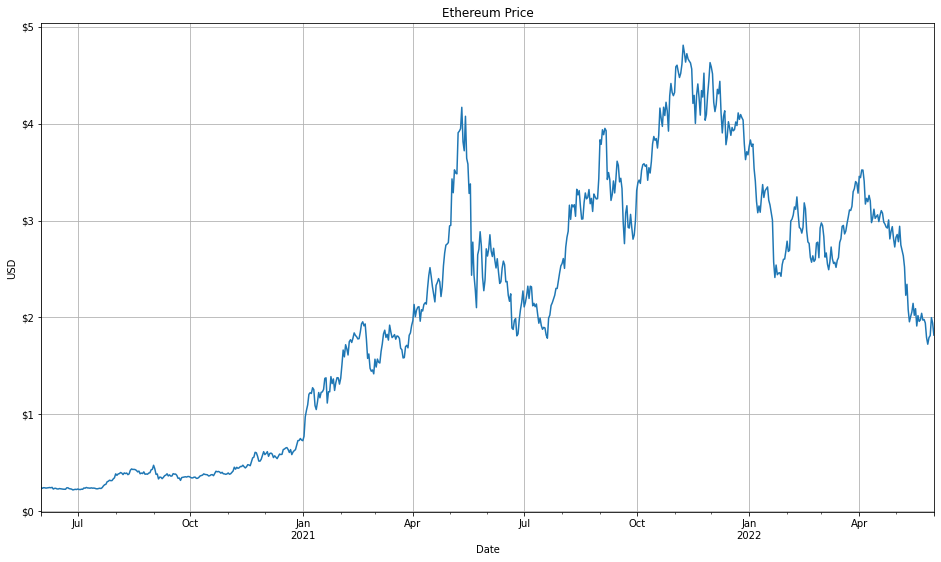

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Ethereum Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.8)], df_scaled[(int)(len(df_scaled) * 0.8):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.8):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (584, 1)
test shape:  (147, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Close'],'Ethereum Price')

Augmented Dickey-Fuller Test: Ethereum Price
ADF test statistic         -1.024066
p-value                     0.744386
Number of lags used         6.000000
Number of observations    577.000000
critical value (1%)        -3.441734
critical value (5%)        -2.866562
critical value (10%)       -2.569445
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

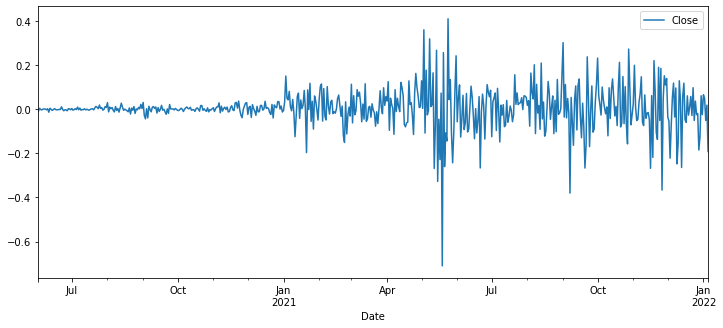

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Ethereum Price First Difference')

Augmented Dickey-Fuller Test: Ethereum Price First Difference
ADF test statistic       -9.079402e+00
p-value                   4.094888e-15
Number of lags used       5.000000e+00
Number of observations    5.770000e+02
critical value (1%)      -3.441734e+00
critical value (5%)      -2.866562e+00
critical value (10%)     -2.569445e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1143.620, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1138.444, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1146.177, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1145.883, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1139.167, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1144.222, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1144.247, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1142.213, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1146.495, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1144.577, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1147.571, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1146.159, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1146.610, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1142.524, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 576.786
Date:                Sat, 25 Jun 2022   AIC                          -1147.571
Time:                        22:40:26   BIC                          -1134.467
Sample:                             0   HQIC                         -1142.464
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8288      0.075    -10.997      0.000      -0.977      -0.681
ma.L1          0.7466      0.095      7.872      0.000       0.561       0.932
sigma2         0.0081      0.000     35.843      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              1774.27
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):              77.45   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([1.11245765, 1.09716666, 1.10983986, 1.09933629, 1.10804167,
       1.10082663, 1.10680647, 1.10185037, 1.10595799, 1.10255359,
       1.10537516, 1.10303664, 1.10497481, 1.10336845, 1.10469981,
       1.10359638, 1.1045109 , 1.10375294, 1.10438114, 1.10386049,
       1.104292  , 1.10393436, 1.10423078, 1.10398511, 1.10418872,
       1.10401997, 1.10415983, 1.10404391, 1.10413998, 1.10406036,
       1.10412635, 1.10407166, 1.10411699, 1.10407942, 1.10411056,
       1.10408475, 1.10410614, 1.10408841, 1.1041031 , 1.10409092,
       1.10410102, 1.10409265, 1.10409959, 1.10409384, 1.1040986 ,
       1.10409465, 1.10409793, 1.10409521, 1.10409746, 1.1040956 ,
       1.10409714, 1.10409586, 1.10409692, 1.10409604, 1.10409677,
       1.10409617, 1.10409667, 1.10409626, 1.1040966 , 1.10409631,
       1.10409655, 1.10409635, 1.10409652, 1.10409638, 1.10409649,
       1.1040964 , 1.10409648, 1.10409641, 1.10409647, 1.10409642,
       1.10409646, 1.10409643, 1.10409645, 1.10409643, 1.10409

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

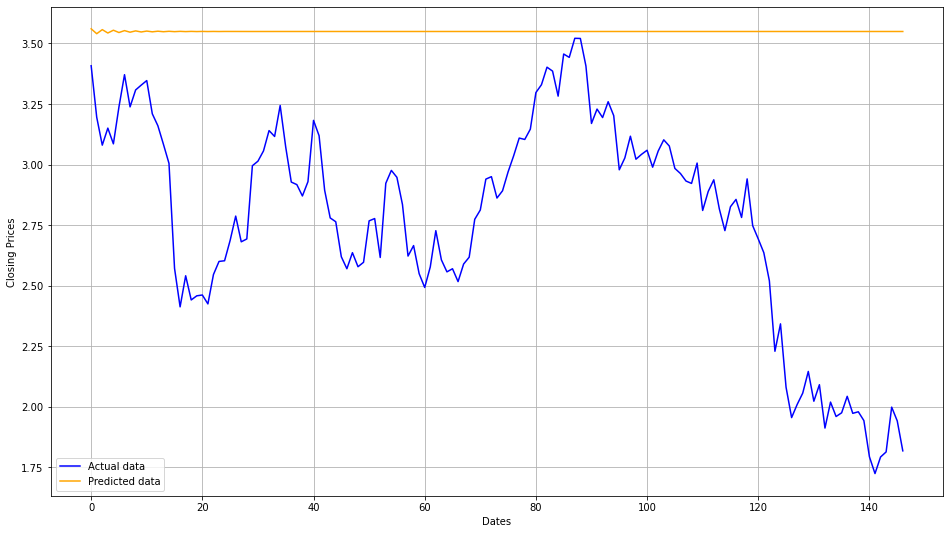

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.77
MAPE: 31.67%
MSE: 0.79
RMSE: 0.89
R2: -3.17


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-01-06,3.40777,3.560321,-0.152551
2022-01-07,3.19531,3.540048,-0.344738
2022-01-08,3.08002,3.556850,-0.476830
2022-01-09,3.15030,3.542924,-0.392624
2022-01-10,3.08543,3.554466,-0.469036
...,...,...,...
2022-05-28,1.79268,3.549235,-1.756555
2022-05-29,1.81356,3.549235,-1.735675
2022-05-30,1.99846,3.549235,-1.550775


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-01-06,3.40777,3.560321,-0.152551
2022-01-07,3.19531,3.540048,-0.344738
2022-01-08,3.08002,3.556850,-0.476830
2022-01-09,3.15030,3.542924,-0.392624
2022-01-10,3.08543,3.554466,-0.469036
...,...,...,...
2022-05-28,1.79268,3.549235,-1.756555
2022-05-29,1.81356,3.549235,-1.735675
2022-05-30,1.99846,3.549235,-1.550775


# Vẽ đồ thị thể hiện sai số

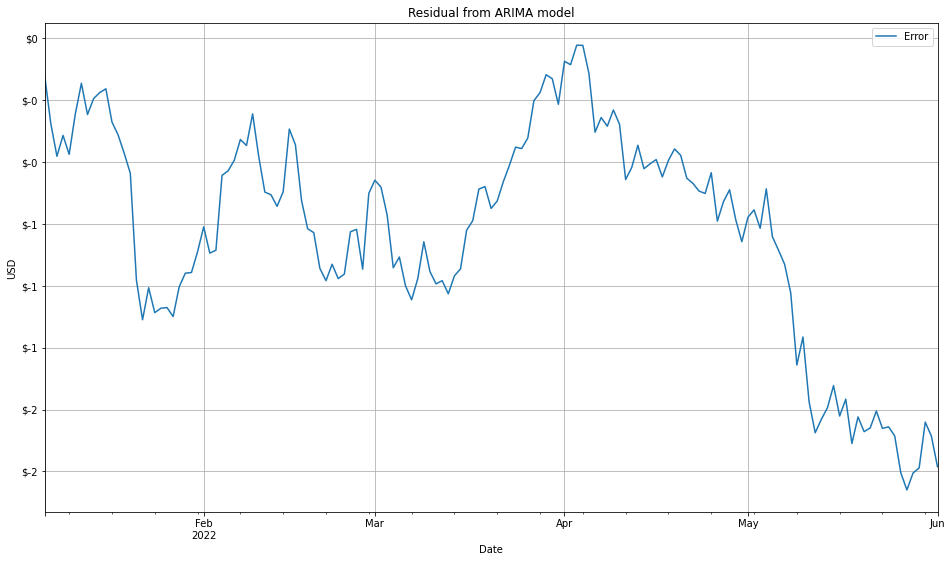

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-0.15255095],
       [-0.34473767],
       [-0.4768302 ],
       [-0.39262424],
       [-0.4690361 ],
       [-0.30701018],
       [-0.18193843],
       [-0.30822748],
       [-0.2438035 ],
       [-0.21944983],
       [-0.20434077],
       [-0.33848027],
       [-0.39024997],
       [-0.4646202 ],
       [-0.54531536],
       [-0.97728239],
       [-1.1372649 ],
       [-1.00796997],
       [-1.10860286],
       [-1.09085256],
       [-1.08808468],
       [-1.12436051],
       [-1.0034635 ],
       [-0.94906779],
       [-0.94658774],
       [-0.862314  ],
       [-0.76215944],
       [-0.86816575],
       [-0.85649312],
       [-0.55419755],
       [-0.53546505],
       [-0.49300253],
       [-0.40908264],
       [-0.43333282],
       [-0.30563411],
       [-0.47738989],
       [-0.62161825],
       [-0.63212475],
       [-0.67899423],
       [-0.61991808],
       [-0.36697146],
       [-0.43033037],
       [-0.65520956],
       [-0.76967195],
       [-0.78542826],
       [-0

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("ethereum_8_2.h5")

Epoch 1/300
5/5 [==============================] - 3s 6ms/step - loss: 0.7496
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 0.6816
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 0.6090
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 0.5208
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 0.4152
Epoch 6/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2785
Epoch 7/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1408
Epoch 8/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0381
Epoch 9/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0525
Epoch 10/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0543
Epoch 11/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0352
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

In [22]:
model = load_model("ethereum_8_2.h5")
error_pred = model.predict(x_train)
error_pred

5/5 [==============================] - 0s 3ms/step


array([[-0.4650204 ],
       [-0.4499731 ],
       [-0.4875077 ],
       [-0.3854361 ],
       [-0.25465682],
       [-0.32358506],
       [-0.29751503],
       [-0.27521068],
       [-0.25542298],
       [-0.34203538],
       [-0.40874735],
       [-0.48674005],
       [-0.5659927 ],
       [-0.93960565],
       [-1.1203238 ],
       [-0.9943101 ],
       [-1.1106454 ],
       [-1.084362  ],
       [-1.0836082 ],
       [-1.1229426 ],
       [-0.9888046 ],
       [-0.94145274],
       [-0.94506305],
       [-0.8616133 ],
       [-0.76635563],
       [-0.8694005 ],
       [-0.8610094 ],
       [-0.577064  ],
       [-0.5384945 ],
       [-0.5277534 ],
       [-0.45400137],
       [-0.46162167],
       [-0.3758228 ],
       [-0.47864115],
       [-0.62003255],
       [-0.6540667 ],
       [-0.6931845 ],
       [-0.6446939 ],
       [-0.42515564],
       [-0.4426527 ],
       [-0.64500207],
       [-0.77159745],
       [-0.7954021 ],
       [-0.93022275],
       [-0.979227  ],
       [-0

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-01-06,3.40777,3.560321,-0.152551,-0.465020
2022-01-07,3.19531,3.540048,-0.344738,-0.449973
2022-01-08,3.08002,3.556850,-0.476830,-0.487508
2022-01-09,3.15030,3.542924,-0.392624,-0.385436
2022-01-10,3.08543,3.554466,-0.469036,-0.254657
...,...,...,...,...
2022-05-25,1.94291,3.549235,-1.606325,-1.912161
2022-05-26,1.79342,3.549235,-1.755815,-1.800873
2022-05-27,1.72430,3.549235,-1.824935,-1.779456


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-01-06,3.40777,3.560321,-0.152551,-0.465020,3.095301
2022-01-07,3.19531,3.540048,-0.344738,-0.449973,3.090075
2022-01-08,3.08002,3.556850,-0.476830,-0.487508,3.069343
2022-01-09,3.15030,3.542924,-0.392624,-0.385436,3.157488
2022-01-10,3.08543,3.554466,-0.469036,-0.254657,3.299809
...,...,...,...,...,...
2022-05-25,1.94291,3.549235,-1.606325,-1.912161,1.637075
2022-05-26,1.79342,3.549235,-1.755815,-1.800873,1.748362
2022-05-27,1.72430,3.549235,-1.824935,-1.779456,1.769779


# Vẽ đồ thị

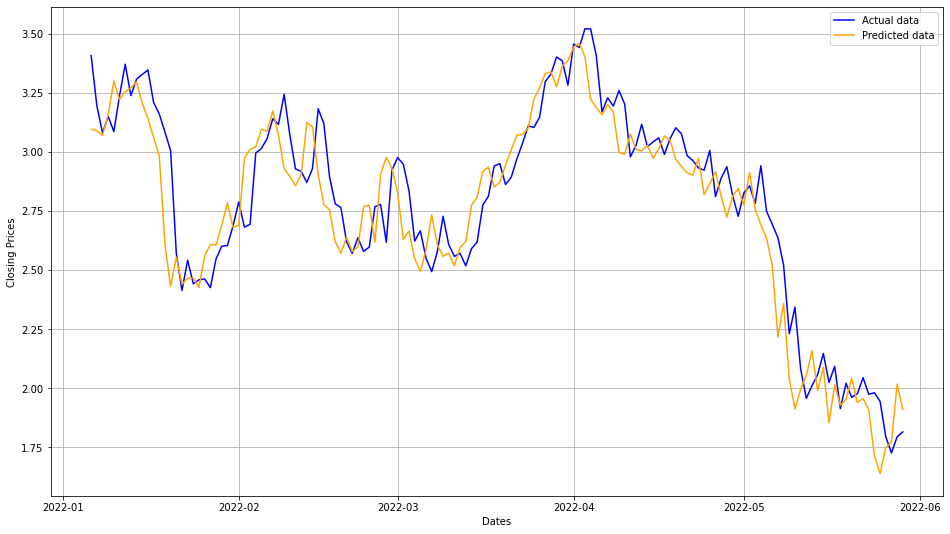

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.12
MAPE: 4.45%
MSE: 0.03
RMSE: 0.16
R2: 0.85


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -1.824935
2022-05-28   -1.756555
2022-05-29   -1.735675
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-1.8249354],
        [-1.7565554],
        [-1.7356754]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 25ms/step


array([-1.779456], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,1.81356,3.549235,-1.735675


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,1.81356,3.549235,-1.735675,1.769779


# Ghi ra file csv

In [32]:
df.to_csv("eth_processed_data_8_2.csv")
df_scaled.to_csv("eth_scaled_data_8_2.csv")
df_pred.to_csv("eth_ARIMA-PRED_8_2.csv")
df_lstm.to_csv("eth_LSTM_PRED_8_2.csv")
y_arima.to_csv("eth_Forecast_8_2.csv")